In [2]:
push!(LOAD_PATH, pwd()) # put current directory on path
using Revise
using UnPack
#include("ModelHelperFuns.jl")  # load the file
#using .ModelHelperFuns         # bring the module into scope
using CooperativeHuntingPkg
using Plots
default(
    guidefontsize=18,   # controls xlabel, ylabel, title font size
    tickfontsize=12,    # controls axis number labels
    legendfontsize=16,  # controls legend font
    linewidth=3,        # controls default line thickness
    grid = false,        # turns off grid in background
    dpi=200,
    fontfamily="Computer Modern" # font family that matches latex
)
using DifferentialEquations
# pgfplotsx()  # Set PGFPlotsX as the backend # this seems to not work on my computer, or on vscode.
using Measures # helps for adjusting location of axis labels
using LinearAlgebra
using ForwardDiff #this should be able to numerically find a jacobian
using LaTeXStrings
using Polynomials
# saving with bif diagrams
bif_fig_path = "/Users/taliaborofsky/Documents/CH_GroupFormation/CH_manuscript/FIgures/BifurcationDiagrams/"
setprecision(BigFloat, 256)  # Set precision to 256 bits

256

# Label Dictionaries

In [3]:
# these were supposed to load with my package but i guess it didn't work
ylabel_dic = Dict(
    :N1 => L"N_1"*", Scaled Big Prey\nDensity",
    :N2 => L"N_2"*", Scaled Small Prey\nDensity",
    :mean_x => "Mean Experienced\nGroup Size, "*L"\bar{x}",
    :p => L"Predator density, $p$",
    :Nsum => "Sum of Prey Densities,\n"*L"N_1 + N_2",
    :g1 => L"g(1)",
    :g2 => L"g(2)",
    :g3 => L"g(3)"
)

param_label_dic = Dict(
    :α1_of_1 => L"\alpha_1(1)",
    :α2_of_1 => L"\alpha_2(1)",
    :s1 => L"s_1",
    :s2 => L"s_2",
    :H1a => L"H_{1a}",
    :H2a => L"H_{2a}",
    :H2b => L"H_{2b}",
    :A1 => L"Relative Attack Rate of Big Prey, $A_1$",
    :A2 => L"A_2",
    :η2 => L"Growth of Small Prey, $\eta_2$",
    :β2 => L"\beta_2",
    :x_max => L"x_{max}",
    :Tg => "Relative Group Dynamics \nTimescale, "*L"T_g",
    :d => L"d",
    :scale => L"Scale, $\beta_1/\beta_2$"
)

Dict{Symbol, AbstractString} with 15 entries:
  :A1      => L"Relative Attack Rate of Big Prey, $A_1$"
  :α1_of_1 => L"$\alpha_1(1)$"
  :β2      => L"$\beta_2$"
  :H2b     => L"$H_{2b}$"
  :Tg      => "Relative Group Dynamics \nTimescale, \$T_g\$"
  :d       => L"$d$"
  :A2      => L"$A_2$"
  :s1      => L"$s_1$"
  :H1a     => L"$H_{1a}$"
  :H2a     => L"$H_{2a}$"
  :scale   => L"Scale, $\beta_1/\beta_2$"
  :x_max   => L"$x_{max}$"
  :α2_of_1 => L"$\alpha_2(1)$"
  :η2      => L"Growth of Small Prey, $\eta_2$"
  :s2      => L"$s_2$"

# Functions

In [4]:
function find_mangel_clark(N1, N2, params)
    # Mangel and Clark predicted that groups should grow until W(x^*) = W(1)
    # Simplest way: iterate and stop when W(x) < W(1), then return x - 1
    @unpack x_max = params
    W_of_1 = fun_W(1, N1, N2, params)
    for x in 2:x_max
        W_of_x = fun_W(x, N1, N2, params)
        if W_of_x < W_of_1
            return x - 1
        end
    end
    return x_max  # If reach x_max
end

function get_g_equilibria(P, N1, N2, params)
    """
    Finds all the g(x) equilibria for a certain p, N1, N2 combination.
    Assumes population sizes are constant.

    Returns gvec
    """
    x_max = params[:x_max]
    xvec = 1:x_max

    # Get the root for g(1)

    W = fun_W(xvec,N1,N2,params)
    S_of_1_x = fun_S_given_W(W[1], W, params)
    S_of_x_1 = 1 .- S_of_1_x
    c_vec = S_of_x_1./(xvec.*S_of_1_x)
    c_vec[2] = c_vec[2]/2    
    # Compute coefficients for g(1)
    coefficients = [x * prod(c_vec[1:x]) for x in xvec]  # Reverse order
    coeff_full = vcat(-P, coefficients)  # Append -P to the coefficients
    # Find roots
    roots_all = roots(Polynomials.Polynomial(coeff_full))
    
    # Filter real positive roots. there should only be one.
    g1 = real(filter(x -> isreal(x) && real(x) > 0, roots_all)[1])

    # Compute g(x) for each g1 root
    gvec = [prod(c_vec[1:x]) * g1^x for x in xvec]

    return gvec
end


function classify_equilibrium_g(g, N1, N2, params)
    """
    Compute the eigenvalues of the Jacobian matrix for just the dynamics of dg(x)/dt.
    Returns:
    - "Stable (attractive)"
    - "Unstable"
    - "Marginally stable (needs further analysis)"
    - "Indeterminate stability (needs further analysis)"
    """
    # Compute the Jacobian matrix for group dynamics
    J = ForwardDiff.jacobian(u -> fun_dg_nopop(u, params, 1),g[1:end-1])
    #J = Jacobian_g(N1, N2, g, params)

    # Compute the eigenvalues of the Jacobian matrix
    eigenvalues = eigen(J).values
    # Check the real parts of the eigenvalues
    real_parts = real.(eigenvalues)

    # Classify the stability based on the real parts of the eigenvalues
    if all(real_parts .< 0)
        return true
    else
        return false
    end
end
function update_params(paramkey::Symbol, param, params_base::Dict{Symbol, Any})
    # Create a copy of the base parameters
    params = deepcopy(params_base)
    
    # Update the parameter specified by paramkey with the new value
    params[paramkey] = param
    
    # Scale the parameters
    params = scale_parameters(params)
    
    return params
end
function bifurcation_g_input(p, N1, N2, paramkey::Symbol, 
    paramvec, params_base::Dict{Symbol, Any})
    #=
    Loop over elements of paramvec, 
    finding the g equilibrium and stability for each
    paramater value
    =#
    x_max = params_base[:x_max]
    # Initialize arrays to store equilibrium g values and their corresponding stability
    results_g = zeros(length(paramvec), x_max)  # 2D array
    stability_results = Vector{Bool}(undef, length(paramvec))

    # Iterate over paramvec
    for (i, param) in enumerate(paramvec)
        # Update parameters
        params = update_params(paramkey, param, params_base)

        # Find the single equilibrium g vector
        gvec = get_g_equilibria(p, N1, N2, params)

        # Get stability
        stability = classify_equilibrium_g(gvec, N1, N2, params)

        # Store results
        results_g[i, :] = gvec  # Store the vector as a row
        stability_results[i] = stability
    end

    return Dict(
        :results_g => results_g, 
        :stability_results => stability_results
        )
end

function get_x_maximizes_pc_fitness(N1, N2, params)
    xvec = 1:params[:x_max]
    W_of_x = fun_W(xvec, N1, N2, params)  # Use fun_W instead of per_capita_fitness_from_prey_non_dim
    max_index = argmax(W_of_x)
    return max_index
end

function plot_actual_vs_optimal_just_g(
    P, N1, N2, paramkey::Symbol, paramvec, 
    params_base, bifurcation_dic
    )
    """
    Plots the mean experienced group size, the equilibrium group size predicted by Mangel and Clark, 
    and the group size that maximizes per capita fitness.

    Arguments:
        paramkey::Symbol: Label of parameter on the x-axis.
        paramvec::Vector: Parameter values shown.
        params_base::Dict: Dictionary of other parameters.
        bifurcation_dic::Dict: Output from `bifurcation_g_input`.

    Returns:
        Tuple (fig, ax)
    """
    @unpack x_max = params_base
    # Set up figure
    fig = plot()
    
    # Iterate over paramvec and get the optimal and Mangel + Clark group sizes
    x_list_mangel_clark = []
    x_list_optimal = []
    params = deepcopy(params_base)
    for param in paramvec
        params[paramkey] = param
        params = scale_parameters(params)
        x_mc = find_mangel_clark(N1, N2, params)
        push!(x_list_mangel_clark, x_mc)
        x_opt = get_x_maximizes_pc_fitness(N1, N2, params)
        push!(x_list_optimal, x_opt)
    end

    # Plot optimal and Mangel + Clark group sizes
    plot!(
        paramvec, x_list_optimal, color=:cyan, 
        lw=3, label=L"$x$ maximizing $W(x)$"
        )
    plot!(
        paramvec, x_list_mangel_clark, 
        color=:blue, lw=3, 
        label=L"Clark & Mangel $x*$"
        )

    # Calculate mean experienced group size from the results_g element in bifurcation_dic
    x = 1:x_max
    group_densities = bifurcation_dic[:results_g]
    prob_experience_x = group_densities' .* x ./ P

    # Compute E[X] (mean experienced group size)
    mean_exp_x = sum(prob_experience_x .* x, dims=1) # sum over columns

    # Most frequent group size
    most_freq_x = getindex.(Tuple.(argmax(prob_experience_x, dims=1)),1)

    # Plot mean experienced and most frequent group sizes
    plot!(
        paramvec, mean_exp_x', color=:black, 
        lw=3, label=L"Mean Experienced $x$")
    plot!(
        paramvec, most_freq_x', color=:magenta, 
        lw=3, label=L"Most Freq. $x$"
        )

    plot!(xlabel = param_label_dic[paramkey], ylabel = L"Group size, $x$",
    guidefontsize=18)
    return fig
end

function plot_line_g(paramkey::Symbol, x_max, paramvec, results_g, stability_results)
    """
    Plots equilibrium g(x) vs. parameter values with:
    - Solid lines for stable points.
    - Dashed lines for unstable points.
    - Colors indicating different group sizes.

    Arguments:
        paramkey::Symbol: Label of parameter on the x-axis.
        x_max::Int: Maximum group size.
        paramvec::Vector: Vector of parameter values.
        results_g::Matrix: Matrix of g(x) values (rows = params, cols = group sizes).
        stability_results::Vector{Bool}: true if stable, false otherwise.

    """
    fig = plot()
    group_size_last = min(6, x_max)
    group_sizes = 1:group_size_last

    
    colors = [:red, :orange, :magenta, :purple,
    :blue, :lightblue]
    for x in group_sizes
        gx = results_g[:, x]

        # Separate stable and unstable points
        #=plot_segments!(
            paramvec, gx, stability_results; 
            color = x, plot_legend = false)=#
        plot!(
            paramvec, gx, color = colors[x], lw=3,
            label = L"x=%$x")
        #plot!([],[],color = x, label = L"x=%$x", legend = true)
    end

    xlabel!(L"Scale, $\beta_1/\beta_2$")
    ylabel!("Density of groups \n of size "*L"$x$, $g(x)$")#L"g(x)")
    return fig
end

function plot_leading_eval(paramvec, out_dict, params_base)
    # assumes we're changing scale
    params = deepcopy(params_base)
    leading_eigenvalues = []  # Array to store the leading eigenvalue for each row
    g_mat = out_dict[:results_g]
    for i in 1:size(g_mat, 1)
        scale = paramvec[i]
        params[:scale] = scale 
        params = scale_parameters(params)
        g = g_mat[i, :]  # Extract the current row (group densities)
        
        # Compute the Jacobian matrix
        J = Jacobian_g(N1, N2, g, params)
        
        # Compute the eigenvalues of the Jacobian matrix
        eigenvalues = eigen(J).values
        
        # Find the eigenvalue with the largest real part
        max_real_eigenvalue = eigenvalues[argmax(real.(eigenvalues))]
        
        # Store the leading eigenvalue
        push!(leading_eigenvalues, max_real_eigenvalue)
    end
    plt = plot()
    # Print the leading eigenvalues
    plot!(
        paramvec, leading_eigenvalues, label = nothing,
        ylabel="Leading Eigenvalue")
    return (plt, leading_eigenvalues)
end

plot_leading_eval (generic function with 1 method)

# Check each component with julia code

In [5]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 1.0,
    :A1 => 0.5,
    :A2 => 0.5,
    :η2 => 0.5,
    :β2 => 1.0,
    :α2_fun_type => "constant",
    :x_max => 10,
    :d => 100.0,
    :scale => 5.0,
    :Tg => 1,
    :P => 3.0,
    :N1 => 1.0,
    :N2 => 0.5
)

Dict{Symbol, Any} with 19 entries:
  :A1          => 0.5
  :α1_of_1     => 0.05
  :β2          => 1.0
  :H2b         => 1.0
  :d           => 100.0
  :Tg          => 1
  :A2          => 0.5
  :s1          => 2.0
  :H1a         => 0.0
  :H2a         => 0.0
  :scale       => 5.0
  :P           => 3.0
  :x_max       => 10
  :α2_of_1     => 0.95
  :η2          => 0.5
  :N2          => 0.5
  :N1          => 1.0
  :α2_fun_type => "constant"
  :s2          => 2.0

In [13]:
params = scale_parameters(params_base)
J = ForwardDiff.jacobian(u -> fun_dg_nopop(u, params, 1),fill(0.3,9))
real(eigen(J).values)

9-element Vector{Float64}:
 -96.54765946229952
  -8.1013994249321
  -5.552854066681334
  -2.791980365842325
  -1.5091624628841147
  -0.526307080555506
  -0.31100266083959127
  -0.3036862802629502
  -0.2690438330479944

In [68]:
params_use = deepcopy(params)
@unpack x_max, β1, β2, d = params_use
xvec = 1:x_max
    f_1 = fun_f1(xvec, N1, N2, params_use)
    f_2 = fun_f2(xvec, N1, N2,params_use)
    Tg = 1

    ## for group section
    W = (β1 .* f_1 + β2 .* f_2) ./ xvec
S_x_1 = fun_S_given_W(W,W[1], params_use)

5-element Vector{Float64}:
 0.5
 0.7085806260084773
 0.7455167375460463
 0.6866816983421506
 0.6252165795474309

In [45]:
fun_dg_nopop(gvec,params,1.0)

5-element Vector{Float64}:
  1.1102230246251565e-16
  0.0
  0.0
 -2.0816681711721685e-17
 -1.3877787807814457e-17

In [37]:
methods(fun_dg_nopop)

# 1 method for generic function "fun_dg_nopop" from CooperativeHuntingPkg.ModelFuns:
 [1] fun_dg_nopop(g, params, T)
     @ ~/Documents/CH_GroupFormation/CH_code/Julia_version/CooperativeHuntingPkg/src/ModelFuns.jl:193

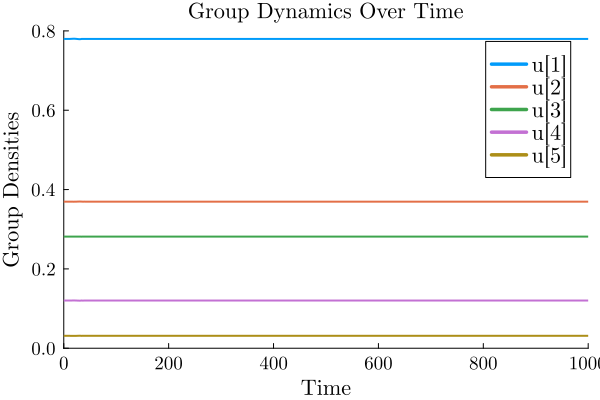

In [35]:
tspan = (0,1000)

prob = ODEProblem(fun_dg_nopop, gvec, tspan, NamedTuple(params))

# Solve the ODE problem
sol = solve(prob)
# Plot the solution
using Plots
plot(
    sol, xlabel="Time", ylabel="Group Densities",
     title="Group Dynamics Over Time",
     ylims = [0,0.8]
     )

# Params base

In [ ]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 1.0,
    :A1 => 0.5,
    :A2 => 0.5,
    :η2 => 0.5,
    :β2 => 1.0,
    :α2_fun_type => "constant",
    :x_max => 10,
    :d => 100.0,
    :scale => 5.0,
    :Tg => 1,
    :P => 10,#:P => 3.0,
    :N1 => 1.0,
    :N2 => 0.5
)

Dict{Symbol, Any} with 19 entries:
  :A1          => 0.5
  :α1_of_1     => 0.05
  :β2          => 1.0
  :H2b         => 1.0
  :d           => 100.0
  :Tg          => 1
  :A2          => 0.5
  :s1          => 2.0
  :H1a         => 0.0
  :H2a         => 0.0
  :scale       => 5.0
  :P           => 3.0
  :x_max       => 10
  :α2_of_1     => 0.95
  :η2          => 0.5
  :N2          => 0.5
  :N1          => 1.0
  :α2_fun_type => "constant"
  :s2          => 2.0

# $d=100$

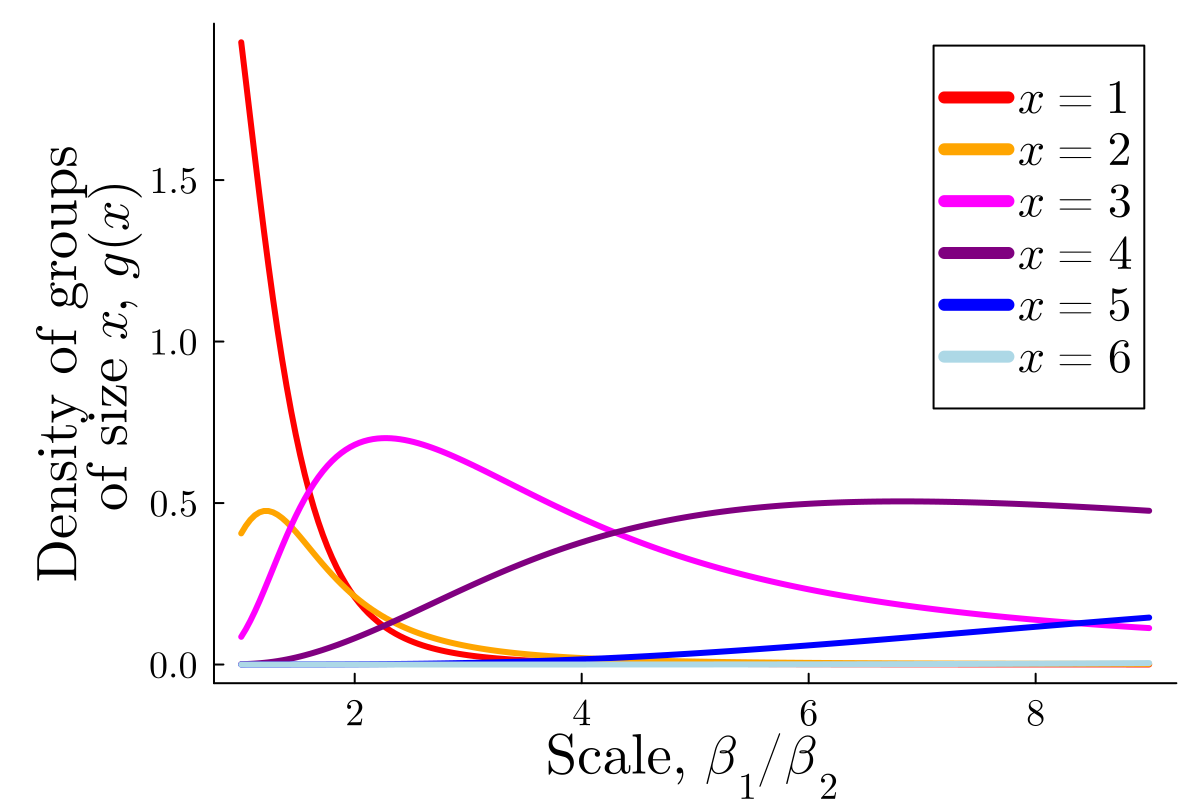

In [13]:

paramkey = :scale
paramvec = collect(1.0:0.04:9.0)
@unpack P, N1, N2, x_max = params_base

out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params_base)
fig = plot_line_g(
    paramkey, x_max, paramvec, out_dict[:results_g], 
    out_dict[:stability_results]
    )
plot!(left_margin=6mm)
savefig(fig, bif_fig_path*"equilibria_only_groups_vs_scale.pdf")
fig


In [10]:
sum(out_dict[:stability_results])

201

## Check that all equilibria are stable

0

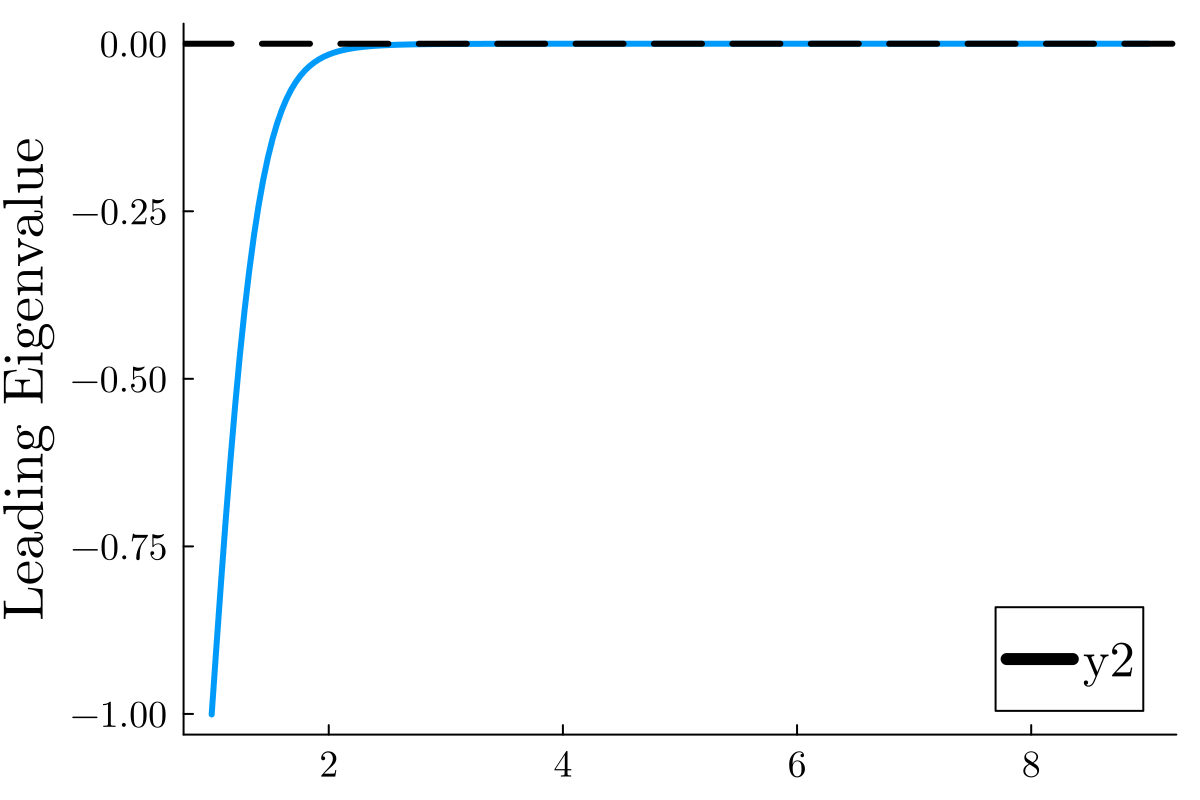

In [12]:
(plt, leading_eigenvalues) = plot_leading_eval(paramvec, out_dict, params_base)
hline!([0], color=:black, linestyle=:dash)
print(sum(real.(leading_eigenvalues) .>= 0))
plt

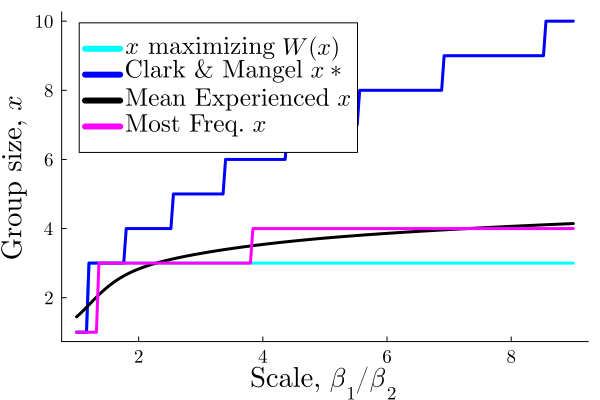

In [8]:
paramkey = :scale
fig = plot_actual_vs_optimal_just_g(
    P, N1, N2, paramkey, 
    paramvec, params_base, out_dict)
savefig(fig, bif_fig_path*"optimal_comparison_only_groups_vs_scale.pdf")
fig

# Type I

In [9]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1.0,
    :α2_fun_type => "constant",
    :x_max => 5,
    :Tg => 0.01,
    :d => 100.0,
    :scale => 5.0,
    :P => 3.0,
    :N1 => 0.2,
    :N2 => 0.6
)


Dict{Symbol, Any} with 19 entries:
  :A1          => 0.6
  :α1_of_1     => 0.05
  :β2          => 1.0
  :H2b         => 0.0
  :Tg          => 0.01
  :d           => 100.0
  :A2          => 0.5
  :s1          => 2.0
  :H1a         => 0.0
  :H2a         => 0.0
  :scale       => 5.0
  :P           => 3.0
  :x_max       => 5
  :α2_of_1     => 0.95
  :η2          => 0.6
  :N2          => 0.6
  :N1          => 0.2
  :α2_fun_type => "constant"
  :s2          => 2.0

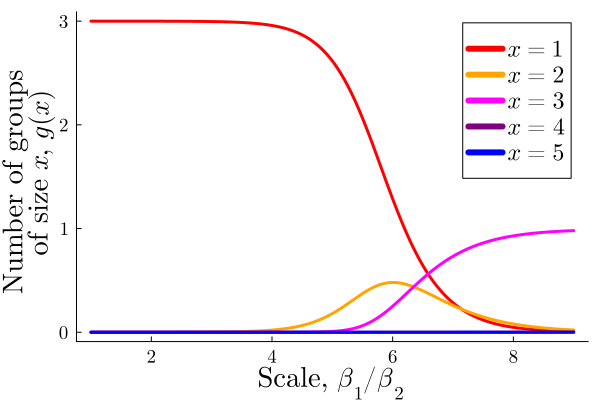

In [14]:
paramkey = :scale
paramvec = collect(1.0:0.04:9.0)
@unpack P, N1, N2 = params_base
out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params_base)
fig = plot_line_g(
    paramkey, params_base[:x_max], paramvec, out_dict[:results_g], 
    out_dict[:stability_results],
    )
plot!(
    ylabel = "Number of groups \n of size "*L"$x$, $g(x)$",
    left_margin = 2mm)

savefig(fig, bif_fig_path*"equilibria_only_groups_vs_scale_t1.pdf")

fig

In [11]:
(plt, leading_eigenvalues) = plot_leading_eval(paramvec, out_dict, params_base)
hline!([0], color=:black, linestyle=:dash)
print(sum(real.(leading_eigenvalues) .>= 0))

0

# Trying to find instability

0

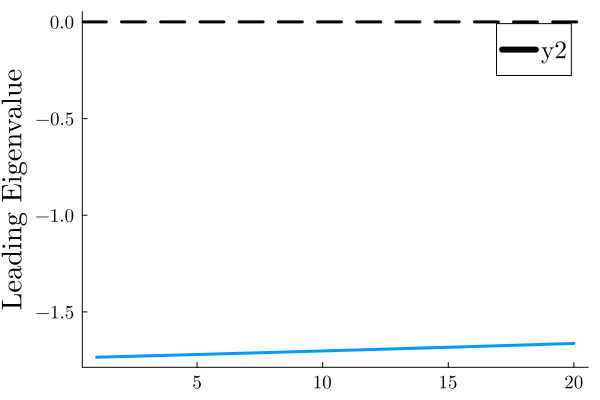

In [35]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.5,
    :A1 => 0.1,
    :A2 => 0.8,
    :η2 => 0.8,
    :β2 => 0.1,
    :α2_fun_type => "constant",
    :x_max => 5,
    :Tg => 0.01,
    :d => 100.0,
    :scale => 5.0,
    :P => 0.2,
    :N1 => 0.1,
    :N2 => 0.9
)

paramkey = :scale
paramvec = collect(1.0:0.04:20.0)
@unpack P, N1, N2 = params_base
out_dict = bifurcation_g_input(P, N1, N2, paramkey, paramvec, params_base)
fig = plot_line_g(
    paramkey, params_base[:x_max], paramvec, out_dict[:results_g], 
    out_dict[:stability_results],
    )
plot!(ylabel = "Density of groups \n of size "*L"$x$, $g(x)$")


fig


(plt, leading_eigenvalues) = plot_leading_eval(paramvec, out_dict, params_base)
hline!([0], color=:black, linestyle=:dash)
print(sum(real.(leading_eigenvalues) .>= 0))
plt

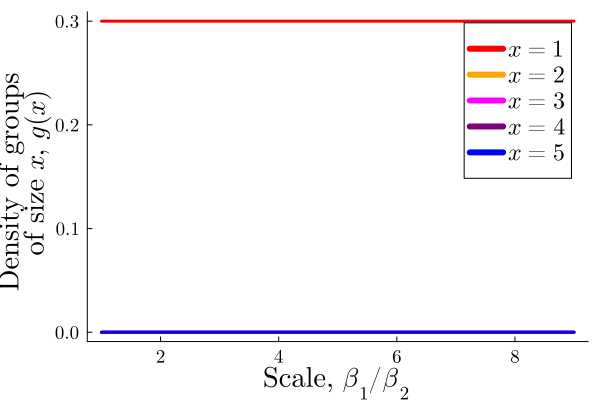